In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization, Embedding, GRU, Dense, Bidirectional, Dropout, LayerNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

# Load Dataset
df = pd.read_csv("final_dataset (1).csv")  # Ensure "Query" and "Label" columns exist
df = df.drop_duplicates()  # Remove duplicate queries
print("Shape after dedup: ", df.shape)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset

X = df["Query"].astype(str).values  # Convert queries to string
y = df["Label"].values  # Labels

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save label encoder for inference
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


# **Vectorizer Setup**
max_tokens = 10000
output_seq_len = 100

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len,
    standardize='lower_and_strip_punctuation'
)

# Adapt vectorizer on training data
vectorizer.adapt(X_train)

vocab = vectorizer.get_vocabulary()
with open("vectorizer_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Save vectorizer configuration
config = vectorizer.get_config()
with open("vectorizer_config.pkl", "wb") as f:
    pickle.dump(config, f)

# **Transform Text Data into Numerical Form**
X_train_vec = vectorizer(X_train).numpy()
X_test_vec = vectorizer(X_test).numpy()

model = keras.Sequential([
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),  # Larger embedding size
    Bidirectional(GRU(64, return_sequences=False)),  # More units for better learning
    LayerNormalization(),  # Helps stabilize training
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation="softmax")
])

# **Compile the Model**
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# **Train the Model**
history = model.fit(X_train_vec, y_train, epochs=10, validation_data=(X_test_vec, y_test), batch_size=32)

Shape after dedup:  (9292, 2)
Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.6452 - loss: 1.0017 - val_accuracy: 0.8531 - val_loss: 0.4227
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9110 - loss: 0.2956 - val_accuracy: 0.8575 - val_loss: 0.4552
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9577 - loss: 0.1579 - val_accuracy: 0.8569 - val_loss: 0.4962
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.9748 - loss: 0.0933 - val_accuracy: 0.8623 - val_loss: 0.5302
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9733 - loss: 0.0832 - val_accuracy: 0.8531 - val_loss: 0.5855
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9836 - loss: 0.0603 - val_accuracy: 0.8575 - val_loss: 0.6543
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.9869 - loss: 0.0571 - val_accuracy: 0.8494 - val_loss: 0.6764
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accu

In [21]:
# **Save Model**
model.save("query_classifier_model.keras")


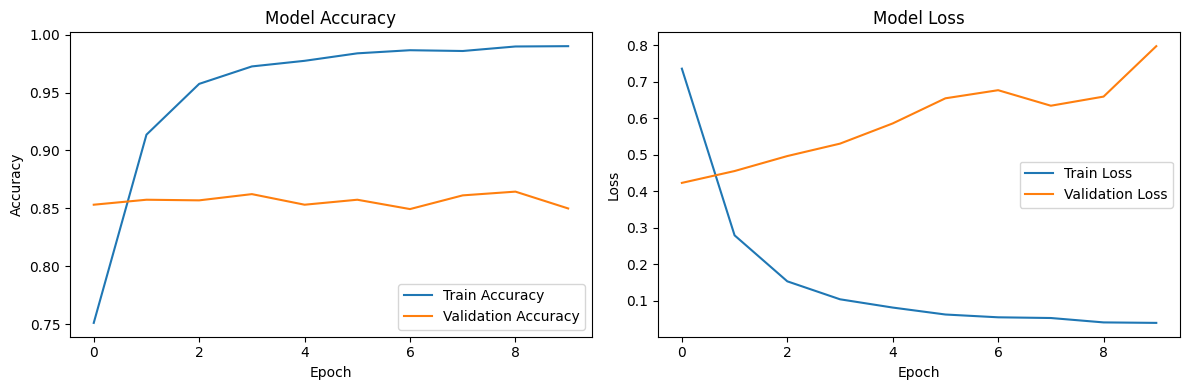

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder

reinforcement_data = []

# **Load Model**
model = tf.keras.models.load_model("query_classifier_model.keras")

# **Load Vectorizer Config**
with open("vectorizer_config.pkl", "rb") as f:
    config = pickle.load(f)

# **Recreate TextVectorization Layer**
vectorizer = tf.keras.layers.TextVectorization.from_config(config)

with open("vectorizer_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
vectorizer.set_vocabulary(vocab)

# **Load Label Encoder**
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# **Function to Classify Queries**
def classify_query(queries):
    if isinstance(queries, str):  # Handle single query
        queries = [queries]

    # Ensure all inputs are strings
    queries = [q if isinstance(q, str) else "" for q in queries]

    # **Convert Text to Vectors**
    vectorized_queries = vectorizer(tf.constant(queries))

    # **Get Model Predictions**
    predictions = model.predict(vectorized_queries)  # Shape: (batch_size, num_classes)

    # **Find Predicted Class Indices**
    predicted_indices = np.argmax(predictions, axis=1)

    # **Convert Indices to Class Labels**
    predicted_labels = label_encoder.inverse_transform(predicted_indices)

    return {
        "classes": label_encoder.classes_.tolist(),
        "scores": predictions.tolist(),
        "predicted_labels": predicted_labels.tolist()
    }

# **Test Example**
example_queries = [
"""
I did not get any issues and everything is working fine, now can you give me flask application that accepts input in the form 
const requestData = {
    instances: queries.map((query) => ({ Query: query })),
  };
And returns the data of in the form that can be handled by the below function,
const predictions = response.data.predictions.map((prediction) => {
      const { classes, scores } = prediction;
      if (!classes || !scores || classes.length === 0 || scores.length === 0) {
        return "text generation"; // Default if no valid data
      }

      // Find index of max score
      const maxIndex = scores.indexOf(Math.max(...scores));
      return classes[maxIndex] || "text generation";
    });
""",
]
print(classify_query(example_queries))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
{'classes': ['code generation', 'image classification', 'image generation', 'question answering', 'summarization', 'text classification', 'text generation'], 'scores': [[0.004776253364980221, 8.747316542212502e-07, 0.00026075245114043355, 0.0004898851620964706, 4.239636837155558e-06, 5.443534246296622e-05, 0.9944135546684265]], 'predicted_labels': ['text generation']}
